In [ ]:
START_DATE = "2022-01-15" # start date for historical data
RSI_TIME_WINDOW = 7 #number of days


import requests
import pandas as pd 
import warnings
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_datareader.data as web
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

In [ ]:
urls = ["https://www.cryptodatadownload.com/cdd/Bitfinex_EOSUSD_d.csv", 
        "https://www.cryptodatadownload.com/cdd/Bitfinex_EDOUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_BTCUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_ETHUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_LTCUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_BATUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_OMGUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_DAIUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_ETCUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_ETPUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_NEOUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_REPUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_TRXUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_XLMUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_XMRUSD_d.csv",
        "https://www.cryptodatadownload.com/cdd/Bitfinex_XVGUSD_d.csv", 
       ]
crypto_names = ["EOS Coin (EOS)",
                "Eidoo (EDO)",
                "Bitcoin (BTC)",
                "Ethereum (ETH)",
                "Litecoin (LTC)",
                "Basic Attention Token (BAT)",
                "OmiseGO (OMG)",
                "Dai (DAI)",
                "Ethereum Classic (ETC)",
                "Metaverse (ETP)",
                "Neo (NEO)",
                "Augur (REP)",
                "TRON (TRX)",
                "Stellar (XLM)",
                "Monero (XMR)",
                "Verge (XVG)"
               ]


In [ ]:
def dataset_loader(urls , start_date = "2021-01-01"):
    filenames = []
    all_dataset = pd.DataFrame()
    for idx,url in enumerate(urls):
        req = requests.get(url,verify=False)
        url_content = req.content
        filename = url[48:]
        csv_file = open( filename , 'wb')
        csv_file.write(url_content)
        csv_file.close()
        filename = filename[:-9]
        filenames.append(filename)
    for file in filenames:
        dataset = pd.read_csv(file + "USD_d.csv", header = 1, parse_dates=["date"])
        dataset = dataset [dataset["date"] > start_date]
        dataset.index = dataset.date
        dataset.drop(labels = [dataset.columns[0],dataset.columns[1],dataset.columns[8]] , axis = 1 , inplace = True)
        all_dataset = pd.concat([all_dataset,dataset], ignore_index=False)

    return all_dataset , filenames 
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[ diff>0 ]
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg = up_chg.ewm(com=time_window-1, min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1, min_periods=time_window).mean()
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

all_dataset , filenames = dataset_loader(urls , start_date=START_DATE)

crypto_dataset = []
for file in filenames:
    symbol = file + str("/USD")
    temp_dataset = pd.DataFrame(all_dataset[all_dataset["symbol"] == symbol])
    temp_dataset.drop(columns= ["symbol"] ,inplace = True)
    temp_dataset["close_rsi"] = computeRSI(temp_dataset['close'], time_window=RSI_TIME_WINDOW)
    temp_dataset["high_rsi"] = 30
    temp_dataset["low_rsi"] = 70
    exec('%s = temp_dataset.copy()' % file.lower())
    crypto_dataset.append(temp_dataset)

## plot 
fig = make_subplots(rows=3, 
                    cols=2,
                    shared_xaxes=True,
                    specs=[[{"rowspan": 2}, {"rowspan": 2}], [{"rowspan": 1}, {"rowspan": 1}] , [{},{}]]
                    
                   )
date_buttons = [
{'step': "all", 'label': "All time"},
{'count':  1, 'step': "year", 'stepmode': "backward", 'label': "Last Year"},
{'count':  1, 'step': "year", 'stepmode': "todate", 'label': "Current Year"},
{'count':  1, 'step': "month", 'stepmode': "backward", 'label': "Last 2 Months"},
{'count':  1, 'step': "month", 'stepmode': "todate", 'label': "Current Month"},
{'count':  7, 'step': "day", 'stepmode': "todate", 'label': "Current Week"},
{'count':  4, 'step': "day", 'stepmode': "backward", 'label': "Last 4 days"},
{'count':  1, 'step': "day", 'stepmode': "backward", 'label': "Today"},
               ]
buttons = []
i = 0
j=0
COUNT = 8
vis = [False] * len(crypto_names) * COUNT
for dataset in crypto_dataset:
    for k in range(COUNT):
        vis[j+k] = True
    buttons.append({ 'label' : crypto_names[i],
                     'method' : 'update',
                     'args'   : [{'visible' : vis},
                                {'title'  : crypto_names[i] + ' Charts and Indicators'}
                                ] }
                  )
    i+=1
    j+=COUNT
    vis = [False] * len(crypto_names)* COUNT
for dataset in crypto_dataset:
    fig.add_trace(
        go.Candlestick(x= dataset.index,
                       open  = dataset['open'],
                       high  = dataset['high'],
                       low   = dataset['low'],
                       close = dataset['close'],
                       showlegend =False
                                ),
                  row=1, 
                  col=1)
    fig.add_trace(
        go.Bar(x =dataset.index ,
               y=dataset["Volume USD"],
               showlegend =False, 
               marker_color='aqua'),
        row=3, 
        col=1)
    fig.add_trace(
        go.Scatter(x=dataset.index, y=dataset['close'],
                   mode='lines',
                  showlegend =False,
                   line=dict(color="red", width=4)),
        row=1, 
        col=2)
    fig.add_trace(
        go.Scatter(x=dataset.index,
                   y=dataset['low'],
                   fill='tonexty',
                   mode='lines',
                   showlegend =False,                   
                   line=dict(width=2, color='pink', dash='dash')),
        row=1, 
        col=2)
    fig.add_trace(
        go.Scatter(x=dataset.index, 
                   y=dataset['high'],
                   fill='tonexty',
                   mode='lines',
                   showlegend =False, 
                   line=dict(width=2, color='pink', dash='dash')),
        row=1, 
        col=2)
    fig.add_trace(
        go.Scatter(x=dataset.index, y=dataset['close_rsi'],
                   mode='lines',
                  showlegend =False,
                   line=dict(color="aquamarine", width=4)),
        row=3, 
        col=2)
    fig.add_trace(
        go.Scatter(x=dataset.index,
                   y=dataset['low_rsi'],
                   fill='tonexty', 
                   mode='lines',
                   showlegend =False,                   
                   line=dict(width=2, color='aqua', dash='dash')),
        row=3, 
        col=2)
    fig.add_trace(
        go.Scatter(x=dataset.index, 
                   y=dataset['high_rsi'],
                   fill='tonexty',
                   mode='lines',
                   showlegend =False, 
                   line=dict(width=2, color='aqua', dash='dash')),
        row=3, 
        col=2)
    
    
fig.update_xaxes(
        tickfont = dict(size=15, family = 'monospace', color='#B8B8B8'),
        tickmode = 'array',
        ticklen = 6,
        showline = False,
        showgrid = True,
        gridcolor = '#595959',
        ticks = 'outside')
fig.update_layout(
    spikedistance=100, 
    xaxis_rangeslider_visible=False,
    hoverdistance=1000)
fig.update_xaxes(
    showspikes=True,  
    spikesnap="cursor",
    spikemode="across"
                )
fig.update_yaxes(
    showspikes=True, 
    spikesnap='cursor',
    spikemode="across"                 
                )
fig.update_yaxes(
        tickfont = dict(size=15, family = 'monospace', color='#B8B8B8'),
        tickmode = 'array',
        showline = False,
        ticksuffix = '$',
        showgrid = True,
        gridcolor = '#595959',
        ticks = 'outside')
fig.update_layout(
                  width=1120,
                  height=650,
                  font_family   = 'monospace',
                  xaxis         = dict(rangeselector = dict(buttons = date_buttons)),
                  updatemenus   = [dict(type = 'dropdown',
                                        x = 1.0,
                                        y = 1.108,
                                        showactive = True,
                                        active = 2,
                                        buttons = buttons)],
                  title         = dict(text = '<b>Cryptocurrencies  Dashboard<b>',
                                       font = dict(color = '#FFFFFF' ,size = 22), 
                                       x = 0.50),
                  font          = dict(color="blue"), 
                  annotations   = [
                                  dict( text = "<b>Choose Cryptocurrency: <b>",
                                        font = dict(size = 20 , color = "#ffffff"),
                                        showarrow=False,
                                        x = 1.02, 
                                        y = 1.20,
                                        xref = 'paper', yref = "paper",
                                        align = "left"),
                                  dict( text = "<b>Candlestick Chart <b>",
                                        font = dict(size = 20,  color = "#ffffff"),
                                        showarrow=False,
                                        x = 0.12, 
                                        y = 0.285,
                                        xref = 'paper', yref = "paper",
                                        align = "left"),
                                  dict( text = "<b>Price Chart<b>",
                                        font = dict(size = 20,  color = "#ffffff"),
                                        showarrow=False,
                                        x = 0.82, 
                                        y = 0.285,
                                        xref = 'paper', yref = "paper",
                                        align = "left"),
                                  dict( text = "<b>Volume Traded<b>",
                                        font = dict(size = 20,  color = "#ffffff"),
                                        showarrow=False,
                                        x = 0.14, 
                                        y = -0.53,
                                        xref = 'paper', yref = "paper",
                                        align = "left"),
                                  dict( text = "<b>Relative Strength Index (RSI)<b>",
                                        font = dict(size = 20,  color = "#ffffff"),
                                        showarrow=False,
                                        x = 0.94, 
                                        y = -0.53,
                                        xref = 'paper', yref = "paper",
                                        align = "left")
                  ],
                template= "plotly_dark"
                )    
for i in range(0,16*COUNT):
    fig.data[i].visible = False
for i in range(COUNT):
    fig.data[i].visible = True
fig.layout["xaxis"]["rangeslider"]["visible"] = False
fig.layout["xaxis2"]["rangeslider"]["visible"] = False
fig.layout["xaxis5"]["rangeslider"]["visible"] = True
fig.layout["xaxis6"]["rangeslider"]["visible"] = True
fig.layout["xaxis5"]["rangeslider"]["borderwidth"] = 4
fig.layout["xaxis6"]["rangeslider"]["borderwidth"] = 4
fig.layout["xaxis5"]["rangeslider"]["bordercolor"] = "aqua"
fig.layout["xaxis6"]["rangeslider"]["bordercolor"] = "aqua"
fig.layout["yaxis6"]["ticksuffix"] = ""
fig.layout["yaxis6"]["range"] = [10,100]
fig.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import warnings# ignore the warnings
warnings.filterwarnings('ignore')

In [ ]:
btc=pd.read_csv("/content/BTCUSD_d.csv")
btc.rename(columns={"0" : "Date","1":"Price"},inplace = True)
btc.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume BTC
1681603200000,2023-04-16 00:00:00,BTC/USD,30278,30293,30255,30289,610484.2527402501,20.15531225
1681516800000,2023-04-15 00:00:00,BTC/USD,30462,30575,30192,30278,24085839.34053562,795.48977279
1681430400000,2023-04-14 00:00:00,BTC/USD,30385,30968,30001,30462,79041875.90943828,2594.76974294
1681344000000,2023-04-13 00:00:00,BTC/USD,29884,30563,29867,30389,43517417.02395926,1432.01214334


In [ ]:
eth=pd.read_csv("/content/ETHUSD_d.csv")
eth.rename(columns={"0" : "Date","1":"Price"},inplace = True)
eth.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume ETH
1681603200000,2023-04-16 00:00:00,ETH/USD,2089.4,2092.2,2087.3,2092.1,51622.645765461,24.67503741
1681516800000,2023-04-15 00:00:00,ETH/USD,2100.0,2110.5,2070.7,2089.3,8868396.874879884,4244.67375431
1681430400000,2023-04-14 00:00:00,ETH/USD,2012.6,2135.8,2010.1,2099.3,42263130.52565757,20132.01092062
1681344000000,2023-04-13 00:00:00,ETH/USD,1917.8,2023.3,1900.1,2011.7,30995972.60487944,15407.85037773


In [ ]:
ada=pd.read_csv("/content/BATUSD_d.csv")
ada.rename(columns={"0" : "Date","1":"Price"},inplace = True)
ada.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume BAT
1681603200000,2023-04-16 00:00:00,BAT/USD,0.28483,0.28549,0.28483,0.28549,46.4707002214217,162.77522933
1681516800000,2023-04-15 00:00:00,BAT/USD,0.28512,0.2867,0.27986,0.28642,1135.182587047304,3963.3495812
1681430400000,2023-04-14 00:00:00,BAT/USD,0.28158,0.29066,0.27685,0.28612,6802.828734801823,23776.138455199998
1681344000000,2023-04-13 00:00:00,BAT/USD,0.28235,0.28319,0.2733,0.28155,5371.423412228406,19078.04444052


In [ ]:
dai=pd.read_csv("/content/DAIUSD_d.csv")
dai.rename(columns={"0" : "Date","1":"Price"},inplace = True)
dai.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume DAI
1681603200000,2023-04-16 00:00:00,DAI/USD,0.99855,0.99858,0.99855,0.99858,5.8913052404382,5.89968279
1681516800000,2023-04-15 00:00:00,DAI/USD,0.9982,1.0019,0.9982,0.9982,8487.176000522351,8502.48046536
1681430400000,2023-04-14 00:00:00,DAI/USD,0.99869,1.0042,0.9982,0.99903,39645.494907794775,39683.98837652
1681344000000,2023-04-13 00:00:00,DAI/USD,0.99887,1.0052,0.9972,0.99882,66750.25595586331,66829.11431075


In [ ]:
edo=pd.read_csv("/content/EDOUSD_d.csv")
edo.rename(columns={"0" : "Date","1":"Price"},inplace = True)
edo.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume EDO
1681603200000,2023-04-16 00:00:00,EDO/USD,0.2172,0.21726,0.21468,0.21726,8.0161279803468,36.89647418
1681516800000,2023-04-15 00:00:00,EDO/USD,0.21291,0.21831,0.21032,0.21721,816.5282401325545,3759.16504826
1681430400000,2023-04-14 00:00:00,EDO/USD,0.2135,0.22094,0.20724,0.21526,661.9894367480108,3075.30166658
1681344000000,2023-04-13 00:00:00,EDO/USD,0.20665,0.21559,0.20427,0.21299,534.2024191973495,2508.11033005


In [ ]:
omg=pd.read_csv("/content/OMGUSD_d.csv")
omg.rename(columns={"0" : "Date","1":"Price"},inplace = True)
omg.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume OMG
1681603200000,2023-04-16 00:00:00,OMG/USD,1.4439,1.4455,1.4394,1.4455,506.06514582169,350.09695318
1681516800000,2023-04-15 00:00:00,OMG/USD,1.4464,1.4518,1.4239,1.4449,69099.38530961836,47822.95335983
1681430400000,2023-04-14 00:00:00,OMG/USD,1.4424,1.4789,1.4184,1.4542,258537.09667693768,177786.47825398
1681344000000,2023-04-13 00:00:00,OMG/USD,1.4221,1.4723,1.4167,1.4429,130076.32539443212,90149.23098928


In [ ]:
eos=pd.read_csv("/content/EOSUSD_d.csv")
eos.rename(columns={"0" : "Date","1":"Price"},inplace = True)
eos.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume EOS
1681603200000,2023-04-16 00:00:00,EOS/USD,1.2409,1.2421,1.2394,1.2421,6408.245923307258,5159.20290098
1681516800000,2023-04-15 00:00:00,EOS/USD,1.2473,1.2503,1.23,1.2412,155036.2144396223,124908.32616792
1681430400000,2023-04-14 00:00:00,EOS/USD,1.2601,1.2949,1.2121,1.2487,615014.1913578609,492523.577607
1681344000000,2023-04-13 00:00:00,EOS/USD,1.2067,1.274,1.1999,1.2583,346804.3118465971,275613.37665628


In [ ]:
trx=pd.read_csv("/content/TRXUSD_d.csv")
trx.rename(columns={"0" : "Date","1":"Price"},inplace = True)
trx.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume TRX
1681603200000,2023-04-16 00:00:00,TRX/USD,0.06598,0.06598,0.065958,0.065958,32.187504000000004,488.0
1681516800000,2023-04-15 00:00:00,TRX/USD,0.066194,0.066239,0.065551,0.065897,23497.843473004265,356584.4192149
1681430400000,2023-04-14 00:00:00,TRX/USD,0.065264,0.0671,0.065215,0.066169,162686.15663389675,2458646.1429656898
1681344000000,2023-04-13 00:00:00,TRX/USD,0.065055,0.065428,0.06434,0.065245,331163.35727903235,5075689.4364170795


In [ ]:
rep=pd.read_csv("/content/REPUSD_d.csv")
rep.rename(columns={"0" : "Date","1":"Price"},inplace = True)
rep.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume REP
1681603200000,2023-04-16 00:00:00,REP/USD,8.154,8.1605,8.0943,8.1231,9.446240809989002,1.16288619
1681516800000,2023-04-15 00:00:00,REP/USD,8.1289,8.3036,8.0356,8.1787,1471.7508761777099,179.9492433
1681430400000,2023-04-14 00:00:00,REP/USD,8.0591,8.2959,7.6972,8.1096,4855.699696298712,598.75945747
1681344000000,2023-04-13 00:00:00,REP/USD,8.0089,8.0825,7.9022,7.984,1762.0515330032001,220.6978373


In [ ]:
xv=pd.read_csv("/content/XVGUSD_d.csv")
xv.rename(columns={"0" : "Date","1":"Price"},inplace = True)
xv.head()

,,,,,,,,https://www.CryptoDataDownload.com
unix,date,symbol,open,high,low,close,Volume USD,Volume XVG
1681603200000,2023-04-16 00:00:00,XVG/USD,0.0025658,0.0025675,0.0025657,0.0025675,90.18013487979307,35123.71368249
1681516800000,2023-04-15 00:00:00,XVG/USD,0.0026085,0.0026192,0.0025206,0.0025696,2873.799974338428,1118384.17432224
1681430400000,2023-04-14 00:00:00,XVG/USD,0.0026174,0.002668,0.0025208,0.0026078,5769.171987617117,2212275.47650016
1681344000000,2023-04-13 00:00:00,XVG/USD,0.0025464,0.0026597,0.0025119,0.0026401,4601.287492808698,1742845.91220359


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
for i in range(0,len(ada)):
    ada['crypto_name']='ada'
    
for i in range(0,len(btc)):
    btc['crypto_name']='btc'
    
for i in range(0,len(eth)):
    eth['crypto_name']='eth'
for i in range(0,len(dai)):
    dai['crypto_name']='dai'
    
for i in range(0,len(edo)):
    edo['crypto_name']='edo'
    
for i in range(0,len(omg)):
    omg['crypto_name']='omg'
for i in range(0,len(eos)):
    eos['crypto_name']='eos'
    
for i in range(0,len(trx)):
    trx['crypto_name']='trx'
    
for i in range(0,len(rep)):
    rep['crypto_name']='rep'
for i in range(0,len(xv)):
    xv['crypto_name']='xv'

In [ ]:
new_dataset = pd.concat([ada,btc,eth,dai,edo,omg,eos,trx,rep,xv])

In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import matplotlib.pyplot as plt
dataset = pd.read_csv('/content/updated_crypto.csv')
chosen_col = 'close'

In [ ]:
print(len(dataset))
dataset.head()

17651


,date,symbol,open,high,low,close,Volume USD,Volume,Name
0,4/25/2022 0:00,EDO/USD,0.52929,0.52929,0.50078,0.50869,879.307651,1728.572707,ada
1,4/24/2022 0:00,EDO/USD,0.54451,0.54451,0.52930,0.52930,195.227012,368.840000,ada
2,4/23/2022 0:00,EDO/USD,0.54451,0.54451,0.54450,0.54450,3.811500,7.000000,ada
3,4/22/2022 0:00,EDO/USD,0.54231,0.54231,0.54230,0.54230,148.821921,274.427293,ada
4,4/21/2022 0:00,EDO/USD,0.55828,0.55828,0.54230,0.54230,2051.796569,3783.508332,ada


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17651 entries, 0 to 17650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        17651 non-null  object 
 1   symbol      17651 non-null  object 
 2   open        17651 non-null  float64
 3   high        17651 non-null  float64
 4   low         17651 non-null  float64
 5   close       17651 non-null  float64
 6   Volume USD  17651 non-null  float64
 7   Volume      17651 non-null  float64
 8   Name        17651 non-null  object 
dtypes: float64(6), object(3)
memory usage: 1.2+ MB


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
name = dataset['Name'].unique()
currency = []
market =[]

In [ ]:
import plotly.graph_objects as go
from datetime import datetime

In [ ]:
dataset.describe()

,open,high,low,close,Volume USD,Volume
count,17651.000000,17651.000000,17651.000000,17651.000000,1.765100e+04,1.765100e+04
mean,1994.201079,2052.660175,1928.625250,1996.666959,3.433119e+07,2.841821e+06
std,7885.017744,8106.802236,7631.726797,7890.503293,1.085571e+08,1.385074e+07
min,0.001791,0.002099,0.001530,0.001791,0.000000e+00,0.000000e+00
25%,0.673500,0.715100,0.648150,0.672585,2.712329e+04,1.492427e+04
50%,2.744000,2.865000,2.605000,2.743000,4.298524e+05,9.340274e+04
75%,109.080000,114.390000,104.460000,109.360000,1.180969e+07,6.847136e+05
max,67526.000000,68958.000000,66326.000000,67526.000000,2.491339e+09,7.136161e+08


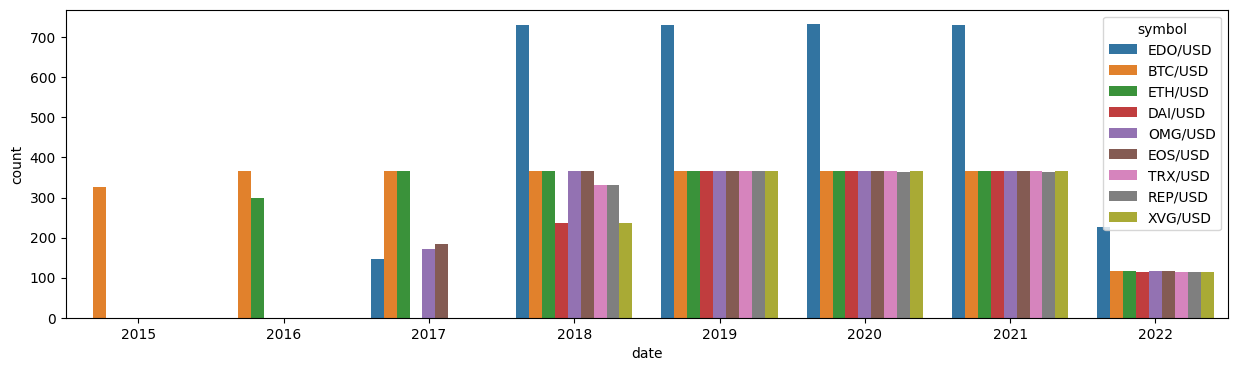

In [ ]:
plt.figure(figsize=(15,4))
sns.countplot(x=pd.DatetimeIndex(dataset['date']).year,hue='symbol',data=dataset)
plt.show()

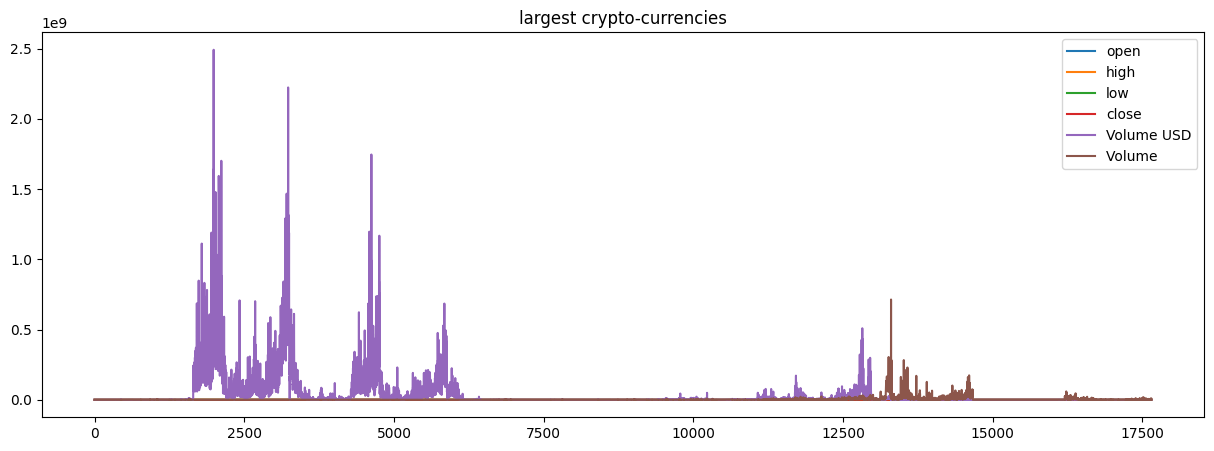

In [ ]:
dataset.plot(figsize=(15,5))
plt.title('largest crypto-currencies')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# Scatter and density plots
def plotScatterMatrix(dataset, plotSize, textSize):
    dataset = dataset.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to dataset being singular
    dataset = dataset.dropna('columns')
    dataset = dataset[[col for col in dataset if dataset[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(dataset)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    dataset = dataset[columnNames]
    ax = pd.plotting.scatter_matrix(dataset, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = dataset.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

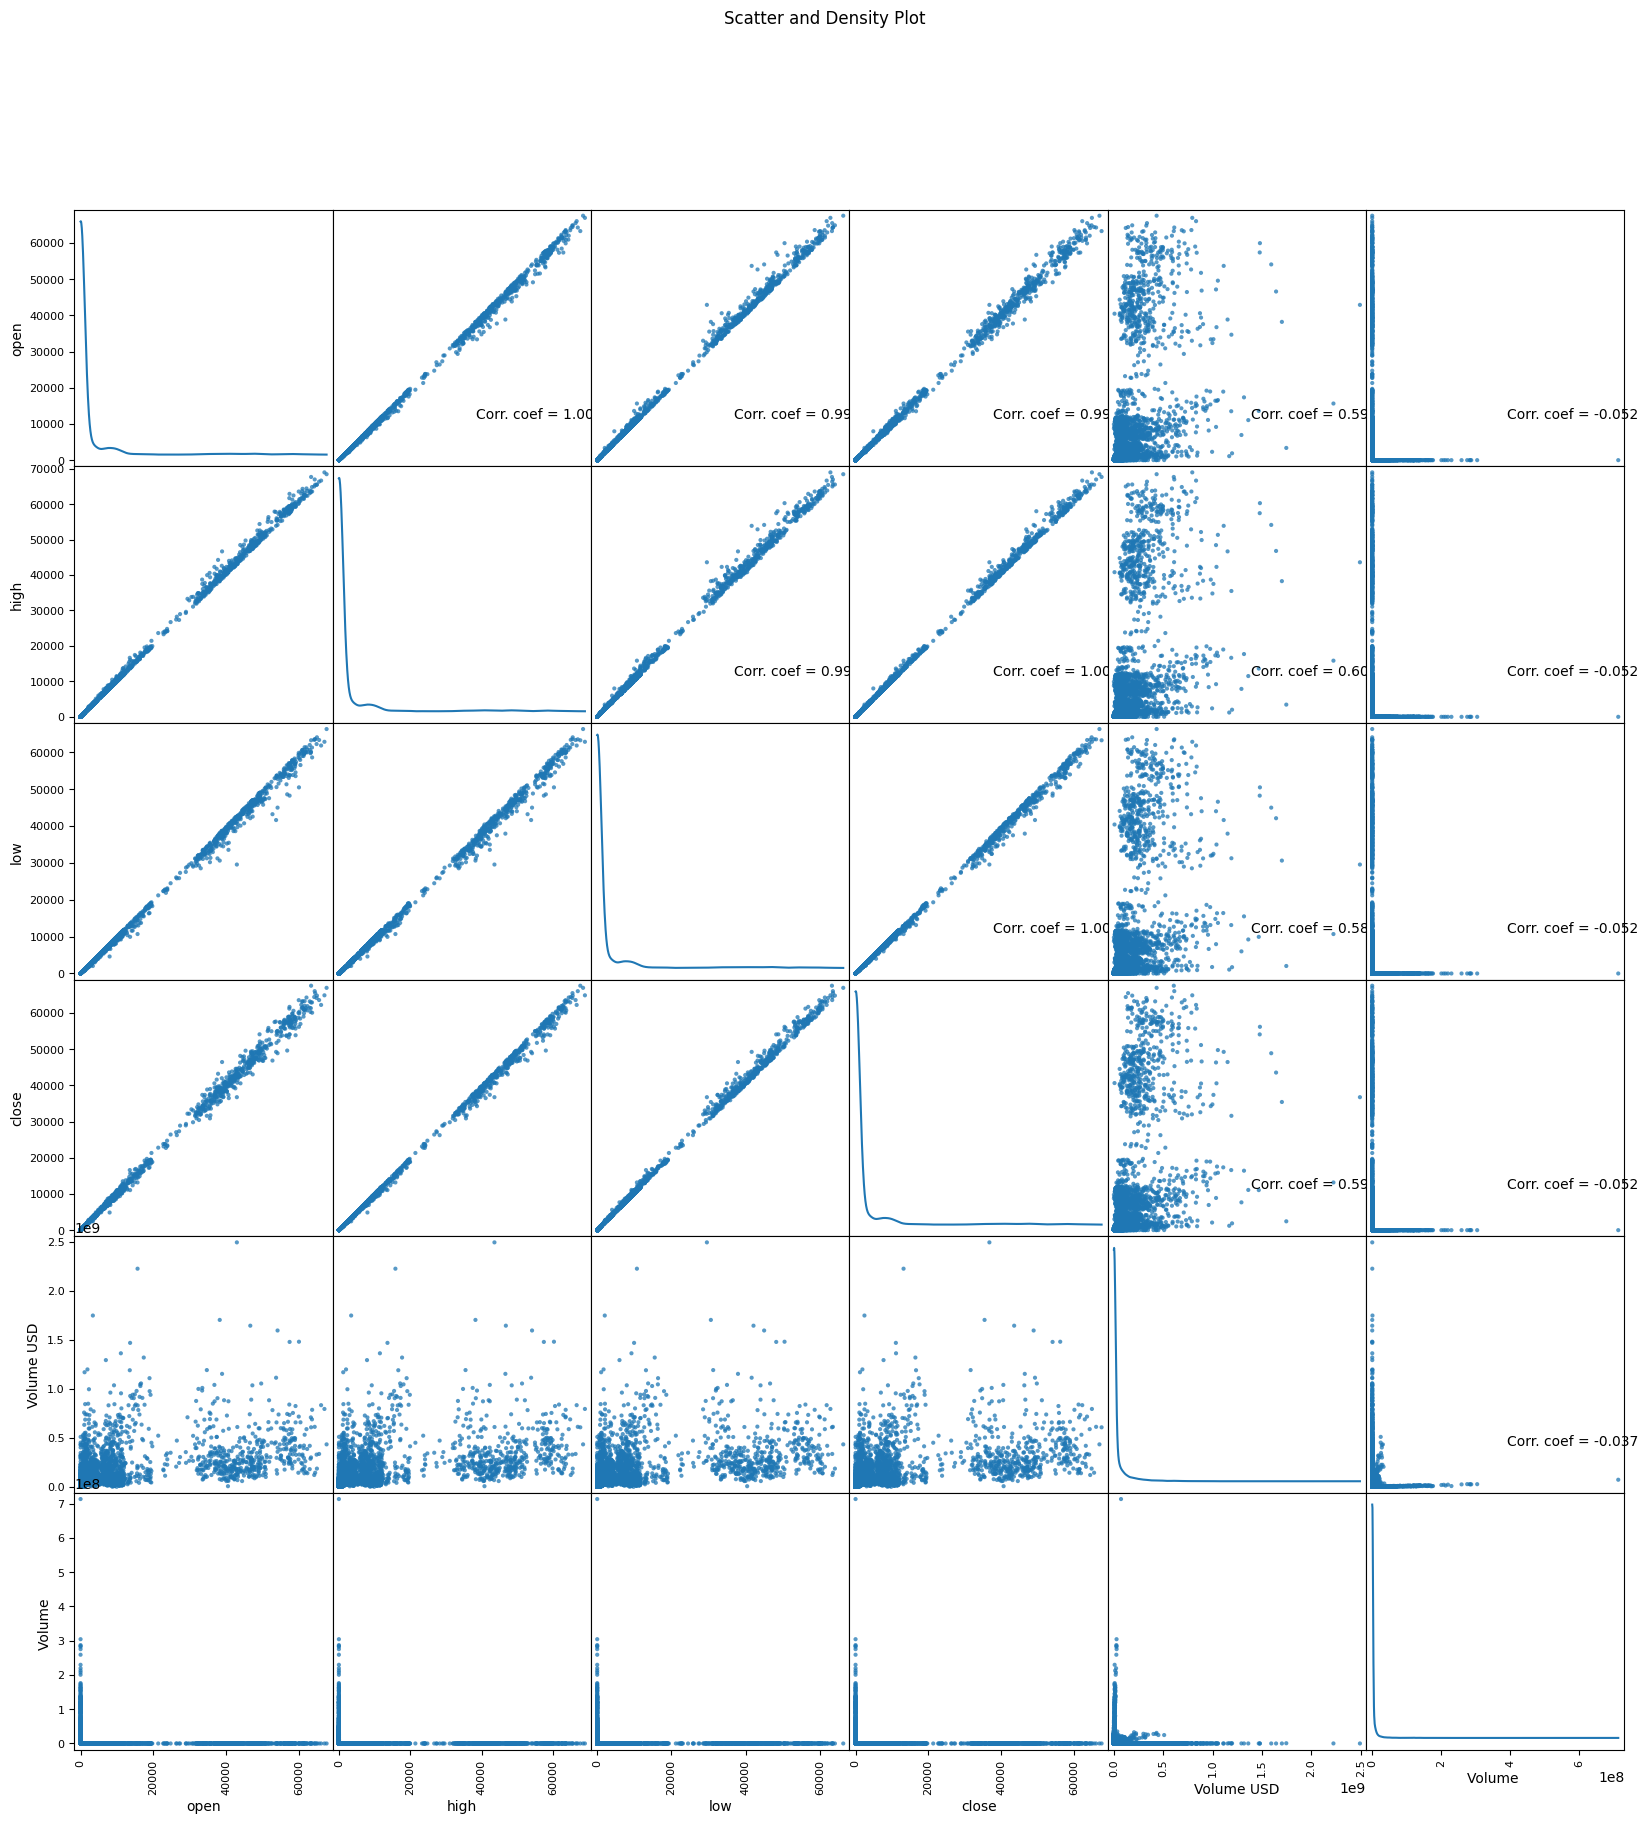

In [ ]:
plotScatterMatrix(dataset, 20, 10)

In [ ]:
def plotCorrelationMatrix(dataset, graphWidth):
    #filename = dataset.dataframeName
    dataset = dataset.dropna('columns') # drop columns with NaN
    dataset = dataset[[col for col in dataset if dataset[col].nunique() > 1]] 
    if dataset.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({dataset.shape[1]}) is less than 2')
        return
    corr = dataset.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for ', fontsize=15)
    plt.show()

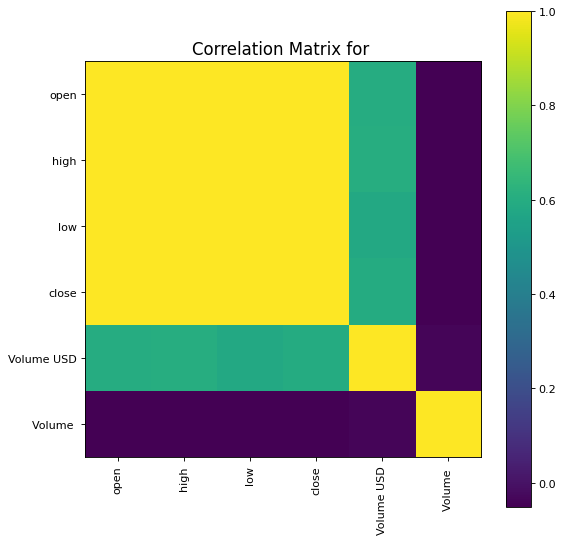

In [ ]:
plotCorrelationMatrix(dataset, 8)

In [ ]:
split_row = len(dataset) - int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]

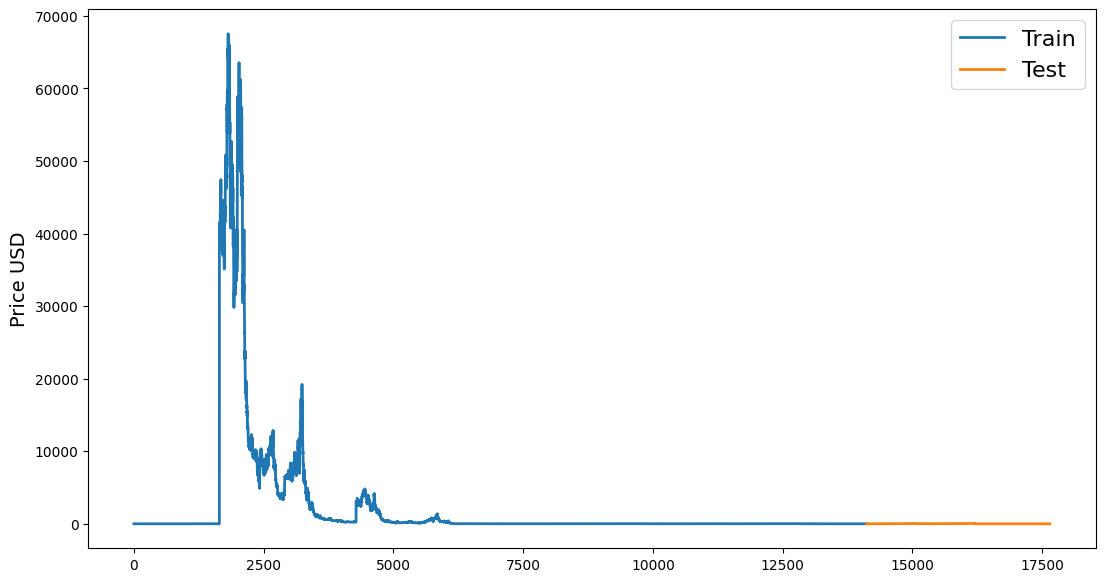

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_data[chosen_col], label='Train', linewidth=2)
ax.plot(test_data[chosen_col], label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

datacol = dataset.iloc[:, 7:8].values
traincol = train_data.iloc[:, 7:8].values
testcol = test_data.iloc[:, 7:8].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)

In [ ]:
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')

In [ ]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/5
352/352 [==============================] - 11s 27ms/step - loss: 2.0815e-04 - val_loss: 9.8305e-05
Epoch 2/5
352/352 [==============================] - 9s 25ms/step - loss: 1.7974e-04 - val_loss: 8.9904e-05
Epoch 3/5
352/352 [==============================] - 11s 32ms/step - loss: 1.7424e-04 - val_loss: 8.4704e-05
Epoch 4/5
352/352 [==============================] - 9s 24ms/step - loss: 1.7590e-04 - val_loss: 8.5816e-05
Epoch 5/5
352/352 [==============================] - 9s 26ms/step - loss: 1.7917e-04 - val_loss: 8.8093e-05


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.metrics import mean_absolute_error

X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

predicted_price = model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

109/109 [==============================] - 1s 8ms/step


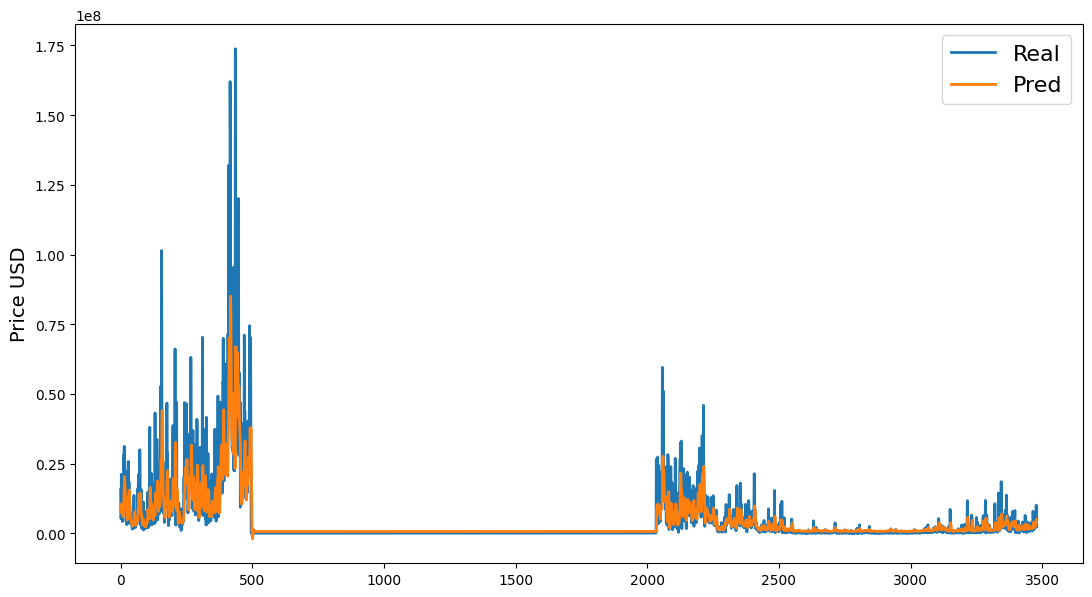

In [ ]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)